In [2]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [5]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

2025-06-18 21:06:18.868435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 21:06:19.251635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750260979.378826      58 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750260979.428669      58 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750260979.837168      58 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


I0000 00:00:1750260985.796353      58 gpu_device.cc:2019] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


True

In [8]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

I0000 00:00:1750260985.807293      58 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
images.as_numpy_iterator().next()

b'data/images/94fbf630-4c3c-11f0-8fe4-74d4dd62a91d.jpg'

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    return tf.io.decode_jpeg(byte_img)

In [11]:
images = images.map(load_image)

In [13]:
image_generator = images.batch(4).as_numpy_iterator()

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params = alb.BboxParams(format='albumentations',label_fields=['class_labels']))

In [19]:
img = cv2.imread(os.path.join('data','train','images','0f72c1c6-4c3c-11f0-a268-74d4dd62a91d.jpg'))

In [20]:
img.shape

(480, 640, 3)

In [21]:
with open(os.path.join('data','train','labels','0f72c1c6-4c3c-11f0-a268-74d4dd62a91d.json'),'r') as f:
    label = json.load(f)

In [22]:
type(label)

dict

In [23]:
label['shapes'][0]['points']

[[160.37037037037035, 87.40740740740742],
 [372.96296296296293, 342.22222222222223]]

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
coords

[160.37037037037035, 87.40740740740742, 372.96296296296293, 342.22222222222223]

In [26]:
coords = list(np.divide(coords,[640,480,640,480]))

In [27]:
coords

[0.25057870370370366,
 0.1820987654320988,
 0.5827546296296295,
 0.712962962962963]

In [28]:
augmented = augmentor(image=img,bboxes=[coords],class_labels=['Person'])

In [29]:
augmented

{'image': array([[[ 75,  99,  97],
         [ 74,  98,  96],
         [ 72,  96,  94],
         ...,
         [ 92, 126, 132],
         [ 89, 123, 129],
         [ 88, 119, 128]],
 
        [[ 72,  96,  94],
         [ 75,  99,  97],
         [ 77, 101,  99],
         ...,
         [ 91, 128, 132],
         [ 89, 125, 131],
         [ 89, 123, 129]],
 
        [[ 73,  99,  99],
         [ 76, 102, 102],
         [ 78, 105, 102],
         ...,
         [ 81, 119, 123],
         [ 82, 120, 125],
         [ 82, 120, 125]],
 
        ...,
 
        [[171, 175, 170],
         [170, 174, 169],
         [173, 177, 172],
         ...,
         [165, 162, 157],
         [163, 163, 157],
         [162, 162, 156]],
 
        [[175, 179, 174],
         [178, 182, 177],
         [183, 187, 181],
         ...,
         [163, 163, 157],
         [162, 163, 154],
         [166, 167, 158]],
 
        [[176, 180, 175],
         [178, 182, 177],
         [179, 183, 177],
         ...,
         [159, 159,

In [30]:
augmented['image'].shape

(450, 450, 3)

In [31]:
augmented['bboxes']

[[0.22008232964409724,
  0.2839505937364366,
  0.6925102912055121,
  0.850205765830146]]

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(100):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [35]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [36]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [37]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [38]:
train_images.as_numpy_iterator().next()

array([[[0.76415443, 0.7798407 , 0.77591914],
        [0.76715684, 0.78382355, 0.7794118 ],
        [0.7759804 , 0.7995098 , 0.7916667 ],
        ...,
        [0.7107843 , 0.74607843, 0.7392157 ],
        [0.6995098 , 0.7348039 , 0.72794116],
        [0.6958946 , 0.7345588 , 0.72677696]],

       [[0.7840074 , 0.79479164, 0.7908701 ],
        [0.7828431 , 0.7995098 , 0.79509807],
        [0.75827205, 0.79356617, 0.78180146],
        ...,
        [0.7162377 , 0.759375  , 0.7436887 ],
        [0.7087622 , 0.7518995 , 0.7362132 ],
        [0.70226717, 0.7454044 , 0.72971815]],

       [[0.77677697, 0.78903186, 0.7757966 ],
        [0.7721201 , 0.7956495 , 0.77996325],
        [0.77457106, 0.8098652 , 0.79025733],
        ...,
        [0.7107843 , 0.75392157, 0.73039216],
        [0.7083333 , 0.75147057, 0.72794116],
        [0.7167279 , 0.7549632 , 0.7434436 ]],

       ...,

       [[0.5987745 , 0.5987745 , 0.48897058],
        [0.57169116, 0.58351713, 0.47763482],
        [0.5744485 , 0

In [39]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6200, 6200, 1500, 1500, 1300, 1300)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(8)
train = train.prefetch(4)

In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

2025-06-18 21:27:08.388310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1727 of 7000
2025-06-18 21:27:28.389998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 6049 of 7000
2025-06-18 21:27:29.130239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.524   , 0.4375  , 0.823   , 0.714   ],
        [0.006092, 0.2388  , 0.4521  , 0.7705  ],
        [0.1549  , 0.2627  , 0.504   , 0.6772  ],
        [0.4465  , 0.2856  , 0.782   , 0.612   ],
        [0.      , 0.      , 0.6187  , 0.695   ],
        [0.1766  , 0.0765  , 0.8135  , 0.781   ],
        [0.      , 0.1792  , 0.5933  , 0.9546  ],
        [0.5713  , 0.1676  , 1.      , 0.734   ]], dtype=float16))

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

2025-06-18 21:28:33.186969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 2027 of 7000
2025-06-18 21:28:53.031936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [57]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [58]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [87]:
facetracker = build_model()

In [88]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      2,049 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [94]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [95]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [96]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.applications import VGG16

# Model
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    vgg = VGG16(include_top=False)(input_layer)

    x = GlobalMaxPooling2D()(vgg)

    # Classification
    class_head = Dense(2048, activation='relu')(x)
    class_output = Dense(1, activation='sigmoid', name='class_output')(class_head)

    # Regression
    reg_head = Dense(2048, activation='relu')(x)
    reg_output = Dense(4, activation='sigmoid', name='bbox_output')(reg_head)

    return Model(inputs=input_layer, outputs=[class_output, reg_output])

# Intersection over Union
def localization_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - y_pred[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = y_pred[:, 3] - y_pred[:, 1]
    w_pred = y_pred[:, 2] - y_pred[:, 0]

    delta_size = tf.reduce_sum(tf.square(h_true - h_pred) + tf.square(w_true - w_pred))
    return delta_coord + delta_size


class FaceTracker(Model):
    def __init__(self, base_model, **kwargs):
        super().__init__(**kwargs)
        self.model = base_model

    def compile(self, optimizer, classification_loss, regression_loss, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        self.closs = classification_loss
        self.rloss = regression_loss

    def train_step(self, data):
        X, y = data
        y_class, y_bbox = y
    
        y_class = tf.cast(y_class, tf.float32)
        y_bbox = tf.cast(y_bbox, tf.float32)
    
        with tf.GradientTape() as tape:
            pred_class, pred_bbox = self.model(X, training=True)
    
            pred_class = tf.reshape(pred_class, (-1,))  # e.g. [batch_size]
            y_class = tf.reshape(y_class, (-1,))
    
            # losses
            loss_class = self.closs(y_class, pred_class)
            loss_bbox = self.rloss(y_bbox, pred_bbox)
            total_loss = loss_bbox + 0.5 * loss_class
    
        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
        return {
            "total_loss": total_loss,
            "classification_loss": loss_class,
            "bbox_loss": loss_bbox
        }


    def test_step(self, data):
        X, y = data
        y_class, y_bbox = y
    
        y_class = tf.cast(y_class, tf.float32)
        y_bbox = tf.cast(y_bbox, tf.float32)
    
        pred_class, pred_bbox = self.model(X, training=False)
    
        # Safe reshape
        pred_class = tf.reshape(pred_class, (-1,))
        y_class = tf.reshape(y_class, (-1,))
    
        loss_class = self.closs(y_class, pred_class)
        loss_bbox = self.rloss(y_bbox, pred_bbox)
        total_loss = loss_bbox + 0.5 * loss_class
    
        return {
            "total_loss": total_loss,
            "classification_loss": loss_class,
            "bbox_loss": loss_bbox
        }


    def call(self, inputs, training=False):
        return self.model(inputs, training=training)


In [173]:
model = FaceTracker(facetracker)

In [174]:
model.compile(opt, classloss, regressloss)

In [2]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [177]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2025-06-18 22:07:46.140277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1583 of 7000
2025-06-18 22:07:56.143097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 3322 of 7000
2025-06-18 22:08:06.143618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 5081 of 7000
2025-06-18 22:08:13.663192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - bbox_loss: 0.1099 - classification_loss: 0.0313 - total_loss: 0.1255

2025-06-18 22:09:25.398615: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 8 bytes spill stores, 8 bytes spill loads

2025-06-18 22:09:25.992427: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_246', 4 bytes spill stores, 4 bytes spill loads

2025-06-18 22:09:26.098876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_246', 12 bytes spill stores, 12 bytes spill loads

2025-06-18 22:09:26.858062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_246', 356 bytes spill stores, 356 bytes spill loads



775/775 ━━━━━━━━━━━━━━━━━━━━ 114s 93ms/step - bbox_loss: 0.1101 - classification_loss: 0.0313 - total_loss: 0.1257 - val_bbox_loss: 0.0272 - val_classification_loss: 0.0097 - val_total_loss: 0.0321
Epoch 2/10


2025-06-18 22:09:39.511995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1691 of 7000
2025-06-18 22:09:59.506574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 4985 of 7000
2025-06-18 22:10:06.482651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 105s 87ms/step - bbox_loss: 0.0571 - classification_loss: 0.0195 - total_loss: 0.0668 - val_bbox_loss: 0.0397 - val_classification_loss: 1.4843e-04 - val_total_loss: 0.0397
Epoch 3/10


2025-06-18 22:11:24.097232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1727 of 7000
2025-06-18 22:11:34.100165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 3230 of 7000
2025-06-18 22:11:44.101079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 4881 of 7000
2025-06-18 22:11:53.211469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 106s 87ms/step - bbox_loss: 0.0379 - classification_loss: 0.0132 - total_loss: 0.0445 - val_bbox_loss: 0.0152 - val_classification_loss: 0.0024 - val_total_loss: 0.0163
Epoch 4/10


2025-06-18 22:13:10.550608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1713 of 7000
2025-06-18 22:13:20.554839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 3423 of 7000
2025-06-18 22:13:40.563345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 6176 of 7000
2025-06-18 22:13:40.906790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - bbox_loss: 0.0671 - classification_loss: 0.0168 - total_loss: 0.0755

2025-06-18 22:14:46.440775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 1042 of 1500
2025-06-18 22:14:48.666511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 113s 93ms/step - bbox_loss: 0.0670 - classification_loss: 0.0168 - total_loss: 0.0754 - val_bbox_loss: 0.0058 - val_classification_loss: 7.1730e-04 - val_total_loss: 0.0061
Epoch 5/10


2025-06-18 22:15:03.408073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 650 of 7000
2025-06-18 22:15:13.411402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1365 of 7000
2025-06-18 22:15:23.418989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1859 of 7000
2025-06-18 22:15:43.405581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 2991 of 7000
2025-06-18 22:15:53.406283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 3643 of 7000
2025-06-18 22:16:03.407395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may tak

775/775 ━━━━━━━━━━━━━━━━━━━━ 168s 88ms/step - bbox_loss: 0.0264 - classification_loss: 0.0098 - total_loss: 0.0313 - val_bbox_loss: 0.0076 - val_classification_loss: 0.0116 - val_total_loss: 0.0134
Epoch 6/10


2025-06-18 22:17:50.919468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1711 of 7000
2025-06-18 22:18:00.922770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 3489 of 7000
2025-06-18 22:18:17.462289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 104s 87ms/step - bbox_loss: 0.0315 - classification_loss: 0.0100 - total_loss: 0.0365 - val_bbox_loss: 0.0040 - val_classification_loss: 0.0025 - val_total_loss: 0.0052
Epoch 7/10


2025-06-18 22:19:34.836281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1683 of 7000
2025-06-18 22:19:54.829306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 4930 of 7000
2025-06-18 22:20:02.748073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 107s 89ms/step - bbox_loss: 0.0473 - classification_loss: 0.0158 - total_loss: 0.0552 - val_bbox_loss: 0.0150 - val_classification_loss: 1.5795e-06 - val_total_loss: 0.0150
Epoch 8/10


2025-06-18 22:21:21.761974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 943 of 7000
2025-06-18 22:21:31.790353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 2267 of 7000
2025-06-18 22:21:51.762373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 4441 of 7000
2025-06-18 22:22:01.766131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 5973 of 7000
2025-06-18 22:22:03.735086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 123s 91ms/step - bbox_loss: 0.0182 - classification_loss: 0.0061 - total_loss: 0.0213 - val_bbox_loss: 0.0041 - val_classification_loss: 0.0032 - val_total_loss: 0.0057
Epoch 9/10


2025-06-18 22:23:24.341842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1595 of 7000
2025-06-18 22:23:44.341771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 4566 of 7000
2025-06-18 22:23:54.342025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 6117 of 7000
2025-06-18 22:23:54.788020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 110s 89ms/step - bbox_loss: 0.0343 - classification_loss: 0.0129 - total_loss: 0.0408 - val_bbox_loss: 0.0037 - val_classification_loss: 3.4579e-04 - val_total_loss: 0.0039
Epoch 10/10


2025-06-18 22:25:14.005548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 1606 of 7000
2025-06-18 22:25:34.016034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:40: Filling up shuffle buffer (this may take a while): 4376 of 7000
2025-06-18 22:25:52.049527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - bbox_loss: 0.0236 - classification_loss: 0.0079 - total_loss: 0.0276

2025-06-18 22:26:58.471963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 1276 of 1500
2025-06-18 22:26:58.853712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


775/775 ━━━━━━━━━━━━━━━━━━━━ 118s 90ms/step - bbox_loss: 0.0236 - classification_loss: 0.0079 - total_loss: 0.0275 - val_bbox_loss: 0.0194 - val_classification_loss: 1.9968e-06 - val_total_loss: 0.0194


KeyError: 'regress_loss'

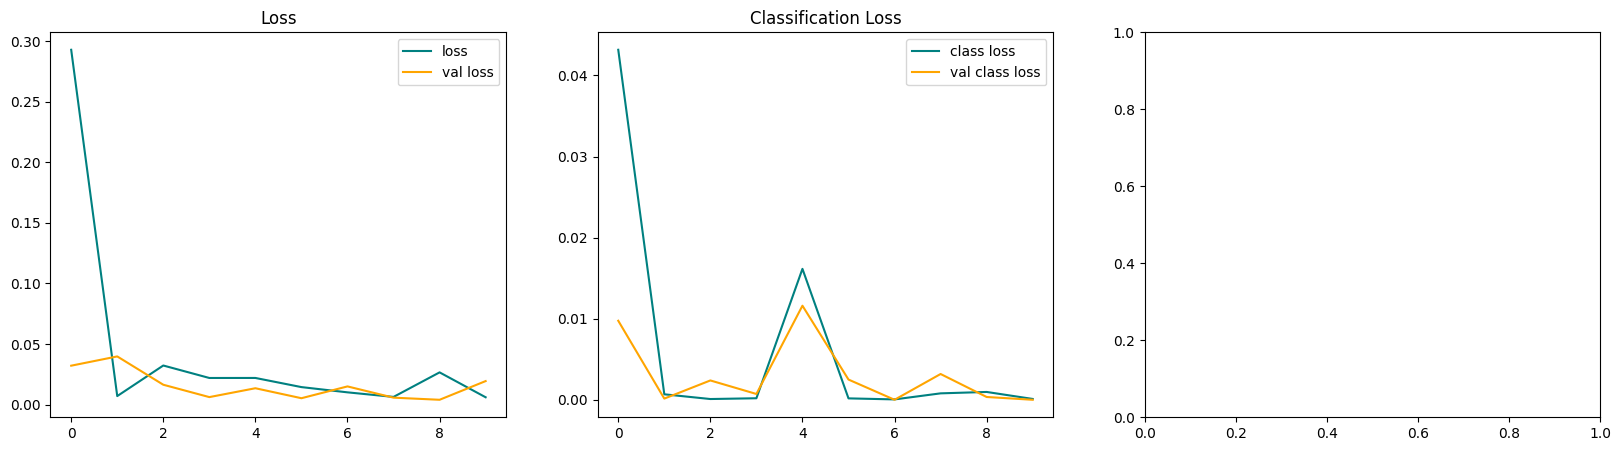

In [184]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [179]:
test_data = test.as_numpy_iterator()

In [180]:
test_sample = test_data.next()

2025-06-18 22:27:45.164931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:44: Filling up shuffle buffer (this may take a while): 1197 of 2000
2025-06-18 22:27:46.943006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [181]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [3]:
from tensorflow.keras.models import load_model

In [187]:
facetracker.save('facetracker.h5')

In [4]:
facetrack = load_model('facetracker.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


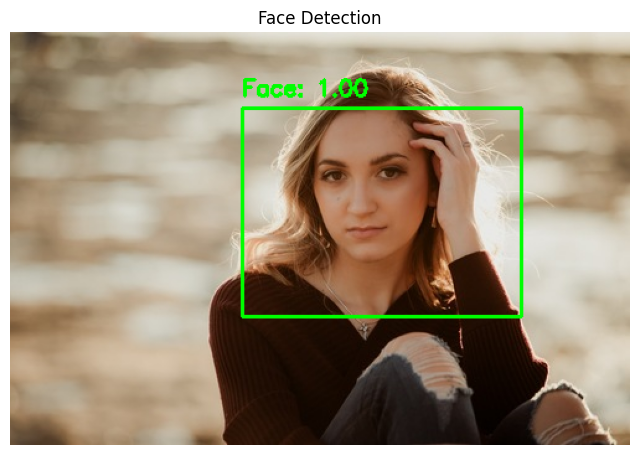

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model
facetrack = load_model('facetracker.h5')

# Load image
img_path = 'face.jpg'
image = cv2.imread(img_path)

# Preprocess
resized_image = cv2.resize(image, (120, 120))
normalized_image = resized_image / 255.0
input_image = np.expand_dims(normalized_image, axis=0)

# Predict
prediction = facetrack.predict(input_image)
face_prob = prediction[0][0][0]
bbox = prediction[1][0]

if face_prob > 0.5:
    h, w = image.shape[:2]
    x1 = int(bbox[0] * w)
    y1 = int(bbox[1] * h)
    x2 = int(bbox[2] * w)
    y2 = int(bbox[3] * h)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, f"Face: {face_prob:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Face Detection")
plt.show()
